# _K_ *N*earest *N*eighbor

In [1]:
# common packages
import tensorflow as tf
import numpy as np
import sys
import os

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.colors import ListedColormap

# download data
from six.moves.urllib.request import urlopen


# Helper to make the output consistent
SEED = 42
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()


# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Version information
print("Python: {}".format(sys.version_info[:]))
print('TensorFlow: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))



Python: (3, 5, 4, 'final', 0)
TensorFlow: 1.4.0
Default GPU Device: /device:GPU:0


## Download Dataset and load into memory

In [2]:
## Download data paths
ROOT_DATA = "../../ROOT_DATA/"
DATA_DIR = "IRIS"

IRIS_TRAINING_PATH = os.path.join(ROOT_DATA, DATA_DIR, "iris_training.csv")
IRIS_TRAINING_URL = "http://download.tensorflow.org/data/iris_training.csv"

IRIS_TEST_PATH = os.path.join(ROOT_DATA, DATA_DIR, "iris_test.csv")
IRIS_TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"

In [3]:
# download data
## training
if not os.path.exists(IRIS_TRAINING_PATH):
    raw = urlopen(IRIS_TRAINING_URL).read()
    with open(IRIS_TRAINING_PATH, "wb") as f:
        f.write(raw)
    print(IRIS_TRAINING_PATH, "path written")
else:
    print(IRIS_TRAINING_PATH, "path exists")

## test
if not os.path.exists(IRIS_TEST_PATH):
    raw = urlopen(IRIS_TEST_URL).read()
    with open(IRIS_TEST_PATH, "wb") as f:
        f.write(raw)
    print(IRIS_TEST_PATH, "path written")
else:
    print(IRIS_TEST_PATH, "path exists")

../../ROOT_DATA/IRIS/iris_training.csv path exists
../../ROOT_DATA/IRIS/iris_test.csv path exists


In [4]:
# Load dataset into memory
training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
                  filename=IRIS_TRAINING_PATH,
                  target_dtype=np.int,
                  features_dtype=np.float32)
test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
              filename=IRIS_TEST_PATH,
              target_dtype=np.int,
              features_dtype=np.float32)

## Quickly show some dataset information

In [5]:
# print some dataset information
print("training shape:", training_set.data.shape)
print("test shape:", test_set.data.shape)

# quick check
assert training_set.data.shape[1] == test_set.data.shape[1], \
    "Rut row raggy, features don't match ({} vs {})".format(training_set.data.shape[1],
                                                            test_set.data.shape[0])
if training_set.data.shape[1] == test_set.data.shape[1]:
    NUM_FEATURES = training_set.data.shape[1]
    print("num features = {}".format(NUM_FEATURES))
    
print("training target information: {} targets, {} classes".format(\
    len(training_set.target), len(set(training_set.target))))
print("test target information: {} targets, {} classes".format(\
    len(test_set.target), len(set(test_set.target))))

training shape: (120, 4)
test shape: (30, 4)
num features = 4
training target information: 120 targets, 3 classes
test target information: 30 targets, 3 classes


In [6]:
# get convenience handle for training and test set data+labels
X_train, Y_train = training_set
X_test, Y_test = test_set

# reduce features to only 2 for visualization
# > we'll plot the decision boundries in 2D
# > in another notebook, we'll use all four features ()
X_train = X_train[:, :2]
X_test = X_test[:, :2]

# get number of unique values in the label
NUM_CLASSES = len(set(Y_train))
if len(set(Y_test)) > len(set(Y_train)):
    print("there is a class present in the test set that is not present in the training set")

NUM_FEATURES = X_train.shape[1]
assert NUM_FEATURES == X_test.shape[1], \
    "Rut row raggy, features don't match ({} vs {})".format(
    training_set.data.shape[1],test_set.data.shape[0])

print(X_train.shape)
print(Y_train.shape)

(120, 2)
(120,)


## Build Model

In [14]:
reset_graph()

# place holders
x_in = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="X")
y_in = tf.placeholder(tf.int32, [None], name="y")
xte = tf.placeholder(tf.float32, [NUM_FEATURES], name="te")

# one-hot encode the labels
y_enc = tf.one_hot(y_in, depth=NUM_CLASSES, axis=1, name="onehot_label")



K = 15
nearest_neighbors = tf.Variable(tf.zeros([K]))

# model
# l1 distance
# > tf.negative is used so that we can can use tf.nn.top_k
# > the value reported by tf.abs is correct, but the largest value equates
# > to the farthest distance.  we'd like the shortest distance.
# > if we make the value negative, now the smallest value is the
# > "best" = closest.
dist = tf.negative(tf.reduce_sum(tf.abs(tf.subtract(x_in, xte)), axis=1))
# l2 distance
# dist = tf.reduce_sum(tf.square(tf.subtract(X, target_x)), axis=1)

# return nearest value
vals, indices = tf.nn.top_k(dist, k=K, sorted=False)

nn = []
for i in range (K):
    nn.append(tf.argmax(y_enc[indices[i]], axis=0))
# let's pretend the input nn value is;
# ---> nn = [3, 3, 1, 3, 2, 2, 4]
# > then
# - y = []
# - idx = []
# - count = []
y, idx, count = tf.unique_with_counts(nn)

pred = tf.slice(y, begin=[tf.argmax(count, 0)], size=tf.constant([1], dtype=tf.int64))[0]

accuracy = 0.0

init = tf.global_variables_initializer()

In [8]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(X_test.shape[0]):
        # return predicted value
        pred_val = sess.run([pred], feed_dict={x_in:X_train,y_in:Y_train,xte:X_test[i,:]})
        print("Test",i,"Prediction",pred_val,"True Class:",Y_test[i])
        if pred_val == Y_test[i]:
            accuracy += 1. / len(X_test)
    print(K,"-th neighbors' Accuracy is:",accuracy)

Test 0 Prediction [1] True Class: 1
Test 1 Prediction [2] True Class: 2
Test 2 Prediction [0] True Class: 0
Test 3 Prediction [2] True Class: 1
Test 4 Prediction [1] True Class: 1
Test 5 Prediction [2] True Class: 1
Test 6 Prediction [0] True Class: 0
Test 7 Prediction [2] True Class: 2
Test 8 Prediction [1] True Class: 1
Test 9 Prediction [2] True Class: 2
Test 10 Prediction [2] True Class: 2
Test 11 Prediction [0] True Class: 0
Test 12 Prediction [1] True Class: 2
Test 13 Prediction [1] True Class: 1
Test 14 Prediction [1] True Class: 1
Test 15 Prediction [0] True Class: 0
Test 16 Prediction [1] True Class: 1
Test 17 Prediction [0] True Class: 0
Test 18 Prediction [0] True Class: 0
Test 19 Prediction [1] True Class: 2
Test 20 Prediction [0] True Class: 0
Test 21 Prediction [1] True Class: 1
Test 22 Prediction [2] True Class: 2
Test 23 Prediction [2] True Class: 1
Test 24 Prediction [1] True Class: 1
Test 25 Prediction [2] True Class: 1
Test 26 Prediction [0] True Class: 0
Test 27 Pre

In [9]:
feat_0_min, feat_0_max = X_train[:, 0].min(), X_train[:, 0].max()
feat_1_min, feat_1_max = X_train[:, 1].min(), X_train[:, 1].max()
# feat_2_min, feat_2_max = X_train[:, 2].min(), X_train[:, 2].max()
# feat_3_min, feat_3_max = X_train[:, 3].min(), X_train[:, 3].max()
step = 0.04
border_padding = 0.15

In [10]:
xx, yy = np.meshgrid(np.arange(feat_0_min-border_padding, feat_0_max+border_padding, step),
                     np.arange(feat_1_min-border_padding, feat_1_max+border_padding, step))
mesh_vals = (np.c_[xx.ravel(), yy.ravel()])
print(mesh_vals.shape)
predictions = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(mesh_vals.shape[0]):
        # return predicted value
        cur_pred = sess.run([pred], feed_dict={x_in:X_train,y_in:Y_train,xte:mesh_vals[i,:]})
        predictions.append(cur_pred)
predictions = np.asarray(predictions)

(6528, 2)


In [11]:
Z = predictions.reshape(xx.shape)
print(Z)

[[0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]
 ..., 
 [0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]]


In [12]:
# Use three colors since we have classes (types of flowers)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

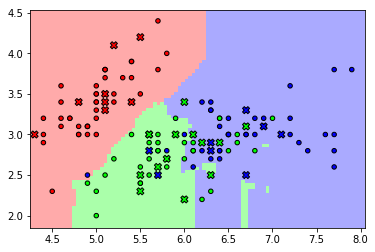

In [13]:
plt.figure()

# plot prediction boundry
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# plot training data as an 'o'
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cmap_bold,
                edgecolor='k', s=20)

# plot test data as an 'x'
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cmap_bold,
                edgecolor='k', s=50, marker='X')
plt.show()